### Functions needed to get abstract

In [26]:
#######1: 对所有在sentences list 里的句子实现SIF embedding
import sys
from scipy.stats import pearsonr
import re
from scipy.stats.stats import pearsonr
   
def get_embedding(sentences,language='Chinese',weightpara=1e-3):
    '''
    This function return the embeddings for all sentences in the input parameter: sentences
    sentences is a list of sentencs need for SIF embeddings
    '''
    sys.path.append('../src')
    import data_io, params, SIF_embedding
    if language=='Chinese':
        #word vector file
        #For model2： 
        wordfile='../models/wiki_news_model2_vector.txt'
        #For model1： 
        #wordfile='../models/wiki_news_word_vector_small2.txt'
        #word frequency file
        weightfile = '../models/word_count.txt' # each line is a word and its frequency
    else:
    #for english use:
        wordfile='../models/glove_small.txt'
        #wordfile='../models/glove.840B.300d.txt'
        weightfile = '../models/enwiki_vocab_min200.txt' # each line is a word and its frequency
    #weightpara = 1e-5
    #weightpara = 1e-3 # the parameter in the SIF weighting scheme, usually in the range [3e-5, 3e-3]
    rmpc = 1 # number of principal components to remove in SIF weighting scheme


    # load word vectors words： 
    (words, We) = data_io.getWordmap(wordfile)
    ##words are all the words in wordfile file
    #print ('words', words)
    #print ('We', We.shape)
    print ('Word map finished')
    word2weight = data_io.getWordWeight(weightfile, weightpara) # word2weight['str'] is the weight for the word 'str'
    print ('word2weight finished')  
    weight4ind = data_io.getWeight(words, word2weight) 
    print ('weight4ind finished ')

    # load sentences
    if language=='Chinese':
        x, m = data_io.sentences2idx_c(sentences, words)
    else:
        x, m = data_io.sentences2idx(sentences, words)
    #print (x.shape) # (句子的数量，最长的句子的单词的数量)
    #print (m.shape) # (句子的数量，最长的句子的单词的数量)

    print ('sentences2idx finished ')
    w = data_io.seq2weight(x, m, weight4ind) # get word weights
    
    print ('seq2weight finished ')
    
    # set parameters
    params = params.params()
    params.rmpc = rmpc

    # get SIF embedding
    """
    return 所有需要计算similarity的title，全文，句子的embedding。
    paper 里面用的是TruncatedSVD，project 要求我们用PCA方法decomposite
    """
    print ('embedding start ')
    embedding = SIF_embedding.SIF_embedding(We, x, w, params,method='PCA') # embedding[i,:] is the embedding for sentence i
   
    print ('embedding finished ')
    print (embedding.shape)
    return embedding

######2: Get similarity scores for splited sentences
def get_similarity_vector(title,content,seperator,weightpara,language='Chinese'):
    '''
    This function get similarity scores for each splited sentences with the title and content of news
    '''
    print ('Title is:', title,'\n')
    if language=='Chinese':
        clean_content=content.replace(' ','').replace('\r\n','')
    else:
        clean_content=content.replace('\r\n','')
    #clean_content=re.findall(r'([\u4e00-\u9fff]+|[A-Z]+|[0-9]+|[a-z])',content)
    print ('Content is :', clean_content,'\n')
    #print ('Seperators are:', seperator,'\n')
    splited_content=list(filter(None, re.split(seperator,clean_content)))
    all_sentences=[title, content] + splited_content
    #print (all_sentences)
    #for a, b  in enumerate(all_sentences):
        #print (a, ' : ', len(b), ' ',  b + '\n')
        
    print ('There are ', str(len(all_sentences)-2), 'sentences been splited and need embeddings.')
    embedding=get_embedding(all_sentences,language,weightpara)
    emb_t=embedding[0]
    emb_c=embedding[1]
    scores=[]
    for i, b in enumerate(all_sentences[2:]):
        #print ('sentences',i, ':', b)
        emb_i=embedding[i+2]
       
        scores.append(0.5*(pearsonr(emb_t,emb_i)[0] + pearsonr(emb_c,emb_i)[0]))
    #print ('scores for all the sentences are:',  scores)
    return scores, all_sentences 


####Step3:  Conduct KNN smooth for scores
def knn_smooth(scores, n_neigbors=3):
    adjusted_scores=[]
    for i, s in enumerate(scores):
        scores_range=scores[max(0,i-n_neigbors):i+n_neigbors+1]
        mean=np.sum(scores_range)/len(scores_range)
        if s<mean:
            adj_s = s+np.abs(mean-s)*0.4
        else:
            adj_s = s-np.abs(mean-s)*0.4
        adjusted_scores.append(adj_s)
    return adjusted_scores

## plot original scores Vs Smoonthed scores
def plot_bar_x(scores, adjusted_scores):
    plt.figure(figsize=(8,8))
    label=list(range(len(scores)))
    # this is for plotting purpose
    index1 = np.arange(len(label))*3
    #print (index1)
    index2=index1+1
    #print (index2)
    plt.bar(index1, scores,label='Original Scores')
    plt.bar(index2, adjusted_scores,label='Smoothed Scores')
    plt.xlabel('Sentences', fontsize=15)
    plt.ylabel('Similarity scores', fontsize=15)
    plt.xticks(index1, label, fontsize=15, rotation=30)
    plt.title('Original scores Vs Smoothed scores')
    plt.legend()
    plt.show()  
    
#####Step 4: return certain % of sentences based on the number of splited sentences
def return_sentences(adjusted_scores,pct_keep):
    #print ('smoothed scores:',adjusted_scores)
    num_of_sentences=min(15,max(1,int(len(adjusted_scores)*pct_keep)))
    abs_index=sorted(range(len(adjusted_scores)), key=lambda i: adjusted_scores[i], reverse=True)[:num_of_sentences]
    return abs_index

### Final function to make the pipeline work and get abstract from a piece of News

>title: Title of the news <br>
content: content of the news <br>
seperator: seperators that been used to split the content into sentences <br>
n_neigbors: number of sentences to used for KNN smoothing <br>
pct_keep: % of sentences to keep for the abstract <br>
language: the language for the news <br>

In [21]:
def get_abstract(title, content,seperator, n_neigbors, pct_keep,weightpara, language):
    """
    title: Title of the news
    content: content of the news
    seperator: seperators that been used to split the content into sentences
    n_neigbors: number of sentences to used for KNN smoothing
    pct_keep: % of sentences to keep for the abstract
    language: the language for the news
    """
    
    abstract=[]
    scores, all_scentences=get_similarity_vector(title,content,seperator,weightpara,language )
    adjusted_scores=knn_smooth(scores,n_neigbors)
    plot_bar_x(scores, adjusted_scores)
    abs_idx=return_sentences(adjusted_scores,pct_keep)
    print ('Abstract of this news is :')
    for _, value in enumerate(sorted(abs_idx)):
        #print (value)
        print (all_scentences[value+2])
        abstract.append(all_scentences[value+2])
    print ('The abstract contains:', len(abstract), ' splited sentences.')
    return ' '.join(abstract)

### Test Case 1 based on Model 2: 
#### Case 1-1:
word vectors: wiki_news_model2_vector.txt   <br>
weight file: word_count.txt<br>
pct_keep=0.5 <br>
weightpara = 1e-3 <br>
n_neigbors=3

Title is: 小米MIUI 9首批机型曝光：共计15款 

Content is : 此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI9的研发之中。MIUI8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI9的确切信息，我们还是等待官方消息。 

There are  16 sentences been splited and need embeddings.
Word map finished
word2weight finished
weight4ind finished 
sentences2idx finished 
seq2weight finished 
embedding start 
emb shape: (18, 100)
PCA used for decompostion PCA(copy=True, iterated_power='auto', n_components=1, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)
embedding finished 
(18, 100)
sentences 0 : 此外
sentences 1 : 自本周
sentences 2 : 6月12日
sentences 3 : 起
sentences 4 : 除小米手机6等15款机型外
sentences 5 : 其余机型已暂停更新发布
sentences 6 : 含开发版/体验版内测
sentences 7 : 稳定版暂不受影响
sentences 8 : 以确保工程师可以集中全部精力进行系统优化工作
sentences 9 : 有人猜测这也是将精力主要用到MIUI9的研发之中
sentences 10 : MIUI8去年5月发布
sentences 11 : 距今已有一年有余
sentences 12 : 也是时候更新换代了
sentences 13 : 当然
sentences 14 : 关于MIUI9的确切信息
sentences 15 : 我们还是等待官方消息
scores for all 

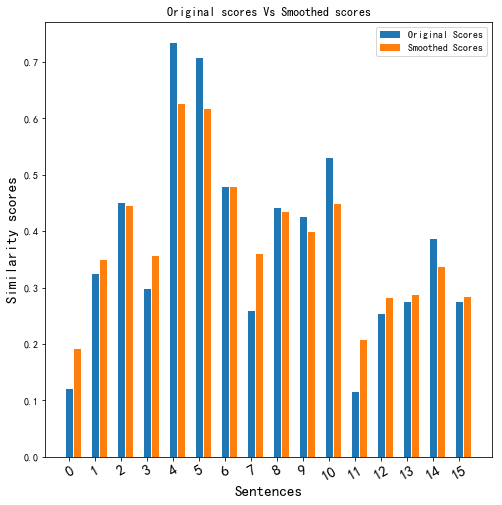

Abstract of this news is :
6月12日
除小米手机6等15款机型外
其余机型已暂停更新发布
含开发版/体验版内测
稳定版暂不受影响
以确保工程师可以集中全部精力进行系统优化工作
有人猜测这也是将精力主要用到MIUI9的研发之中
MIUI8去年5月发布
The abstract contains: 8  splited sentences.
My program took 24.650967121124268 to run


In [22]:
import sys
sys.path.append('../src')
import data_io, params, SIF_embedding
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

import time
start_time = time.time()

title='小米MIUI 9首批机型曝光：共计15款'
content='此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。MIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI 9的确切信息，我们还是等待官方消息。'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.5,weightpara=1e-3,language='Chinese')

print ("My program took", time.time() - start_time, "to run")

#### Case 1-2:
word vectors: wiki_news_model2_vector.txt   <br>
weight file: word_count.txt<br>
pct_keep=0.5 <br>
weightpara = 1e-5 <br>
n_neigbors=3

Title is: 小米MIUI 9首批机型曝光：共计15款 

Content is : 此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI9的研发之中。MIUI8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI9的确切信息，我们还是等待官方消息。 

There are  16 sentences been splited and need embeddings.
Word map finished
word2weight finished
weight4ind finished 
sentences2idx finished 
seq2weight finished 
embedding start 
emb shape: (18, 100)
PCA used for decompostion PCA(copy=True, iterated_power='auto', n_components=1, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)
embedding finished 
(18, 100)
sentences 0 : 此外
sentences 1 : 自本周
sentences 2 : 6月12日
sentences 3 : 起
sentences 4 : 除小米手机6等15款机型外
sentences 5 : 其余机型已暂停更新发布
sentences 6 : 含开发版/体验版内测
sentences 7 : 稳定版暂不受影响
sentences 8 : 以确保工程师可以集中全部精力进行系统优化工作
sentences 9 : 有人猜测这也是将精力主要用到MIUI9的研发之中
sentences 10 : MIUI8去年5月发布
sentences 11 : 距今已有一年有余
sentences 12 : 也是时候更新换代了
sentences 13 : 当然
sentences 14 : 关于MIUI9的确切信息
sentences 15 : 我们还是等待官方消息
scores for all 

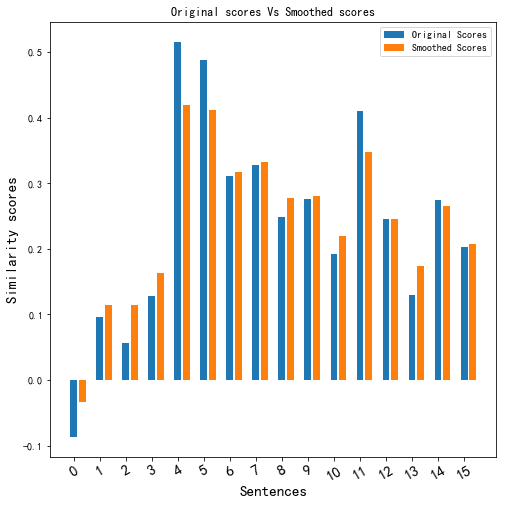

Abstract of this news is :
除小米手机6等15款机型外
其余机型已暂停更新发布
含开发版/体验版内测
稳定版暂不受影响
以确保工程师可以集中全部精力进行系统优化工作
有人猜测这也是将精力主要用到MIUI9的研发之中
距今已有一年有余
关于MIUI9的确切信息
The abstract contains: 8  splited sentences.
My program took 24.62139391899109 to run


In [23]:
import sys
sys.path.append('../src')
import data_io, params, SIF_embedding
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

import time
start_time = time.time()

title='小米MIUI 9首批机型曝光：共计15款'
content='此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。MIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI 9的确切信息，我们还是等待官方消息。'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.5,weightpara=1e-5, language='Chinese')

print ("My program took", time.time() - start_time, "to run")

#### Case 1-3:
word vectors: wiki_news_model2_vector.txt   <br>
weight file: word_count.txt<br>
pct_keep=0.5 <br>
weightpara = 1e-5 <br>
n_neigbors=5

Title is: 小米MIUI 9首批机型曝光：共计15款 

Content is : 此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI9的研发之中。MIUI8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI9的确切信息，我们还是等待官方消息。 

There are  16 sentences been splited and need embeddings.
Word map finished
word2weight finished
weight4ind finished 
sentences2idx finished 
seq2weight finished 
embedding start 
emb shape: (18, 100)
PCA used for decompostion PCA(copy=True, iterated_power='auto', n_components=1, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)
embedding finished 
(18, 100)
sentences 0 : 此外
sentences 1 : 自本周
sentences 2 : 6月12日
sentences 3 : 起
sentences 4 : 除小米手机6等15款机型外
sentences 5 : 其余机型已暂停更新发布
sentences 6 : 含开发版/体验版内测
sentences 7 : 稳定版暂不受影响
sentences 8 : 以确保工程师可以集中全部精力进行系统优化工作
sentences 9 : 有人猜测这也是将精力主要用到MIUI9的研发之中
sentences 10 : MIUI8去年5月发布
sentences 11 : 距今已有一年有余
sentences 12 : 也是时候更新换代了
sentences 13 : 当然
sentences 14 : 关于MIUI9的确切信息
sentences 15 : 我们还是等待官方消息
scores for all 

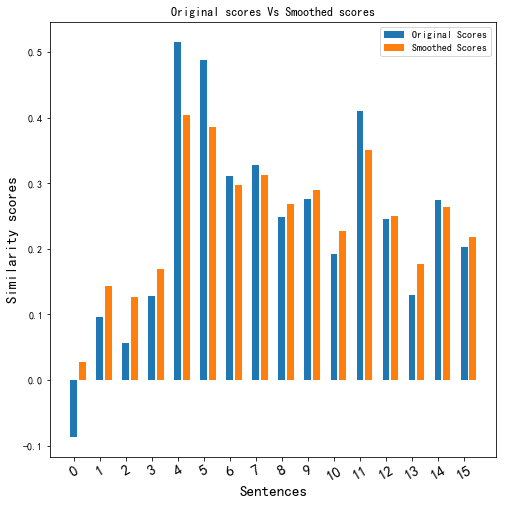

Abstract of this news is :
除小米手机6等15款机型外
其余机型已暂停更新发布
含开发版/体验版内测
稳定版暂不受影响
以确保工程师可以集中全部精力进行系统优化工作
有人猜测这也是将精力主要用到MIUI9的研发之中
距今已有一年有余
关于MIUI9的确切信息
The abstract contains: 8  splited sentences.
My program took 24.7624249458313 to run


In [24]:
start_time = time.time()
title='小米MIUI 9首批机型曝光：共计15款'
content='此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。MIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI 9的确切信息，我们还是等待官方消息。'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=5,pct_keep=0.5, weightpara=1e-5,language='Chinese')

print ("My program took", time.time() - start_time, "to run")

### According to the 3 test cases above: 
#### case 1-1:<br>
weightpara = 1e-3 <br>
n_neigbors=3<br>
provide the best test results.

### Test Case 2 based on Model 2:
#### case 2-1:
pct_keep=0.3<br>
weightpara = 1e-3 <br>
n_neigbors=3<br>

Title is: 早间机构看市：市场将再次探底 两类股逢低布局 

Content is : ?　　巨丰早评：市场将再次探底　　【巨丰观点】　　周四大盘冲高回落，2500余只个股下跌。上证50、沪深300指数顽强收红。早盘大盘低开高走，展开反弹，沪指冲破120日均线压力位；午后大盘跳水，个股普跌。盘面上，保险、电力、银行、民航机场、券商、房地产、人工智能、迪士尼、网络安全等板块涨幅居前。雄安新区、福州新区、医疗器械、丝绸之路等跌幅居前。　　金融股全线大涨：保险板块涨3%：新华保险、中国太保、中国人寿涨4%，中国平安涨2%；西水股份、天茂集团盘中大涨7%以上。银行板块涨2%：招商银行大涨8%，贵阳银行、兴业银行、浦发银行、兴业银行等涨幅居前。金融股是A股纳入MSCI指数的受益者，后市可以逢低关注。　　盘中万达电影、复星医药等白马股闪崩，导致午后市场出现大幅跳水。盘后消息，银监会于6月中旬要求各家银行排查包括万达、海航集团、复星、浙江罗森内里在内数家企业的授信及风险分析，排查对象多是近年来海外投资比较凶猛、在银行业敞口较大的民营企业集团。　　巨丰投顾认为自5月以来，大盘已经走出了3重底的走势，并开启中级反弹行情。沪指在上证50及白马股推动下率先反弹，但遭遇60日、120日均线强压力而出现调整。MSCI纳入A股后，沪深300指数创17个月新高，但2500余股下跌，市场分化明显。随着6月末市场流动性紧张的可能出现，市场将再次出现探底。建议投资者重点关注半年报大幅预增的错杀股和具备估值优势的大蓝筹。　　天信投资：尾盘跳水原因揭秘伏击的品种曝光　　周四市场点评：　　沪深两市早盘纷纷低开，但是开盘之后权重板块崛起，其中保险和银行表现尤其明显，低矮动股指快速拉升，并顺势突破了60日均线和半年线的束缚；在主板拉升的过程中，市场的分化格局也较明显，题材板块和创业板表现相对较弱。不过虽然市场在早盘的上攻，但是成交量萎缩明教明显，所以这种上涨比较虚。果不其然，午后个股再度纷纷杀跌，同时股指也是顺势回落，沪市的半年线得而复失，形成长长的上影线；而创业板股指在回落的过程中失守5日均线的支撑。整体上周四市场全天保持宽幅震荡走势，尤其是沪市冲高回落。保险、银行、中字头、举牌等品种涨幅居前；钛金属、区块链、雄安新区、民营医院等品种领跌。　　今日市场预测：　　在周三收市的评论中，我们指出周四市场会出

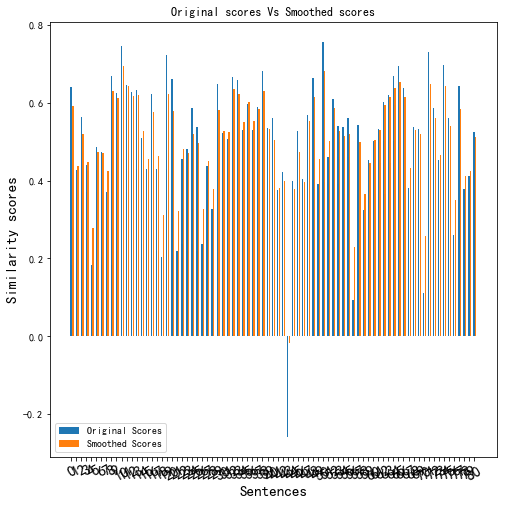

Abstract of this news is :
保险、电力、银行、民航机场、券商、房地产、人工智能、迪士尼、网络安全等板块涨幅居前
　　金融股全线大涨：保险板块涨3%：新华保险、中国太保、中国人寿涨4%
中国平安涨2%；西水股份、天茂集团盘中大涨7%以上
银行板块涨2%：招商银行大涨8%
贵阳银行、兴业银行、浦发银行、兴业银行等涨幅居前
银监会于6月中旬要求各家银行排查包括万达、海航集团、复星、浙江罗森内里在内数家企业的授信及风险分析
建议投资者重点关注半年报大幅预增的错杀股和具备估值优势的大蓝筹
　　天信投资：尾盘跳水原因揭秘伏击的品种曝光　　周四市场点评：　　沪深两市早盘纷纷低开
市场的分化格局也较明显
保险、银行、中字头、举牌等品种涨幅居前；钛金属、区块链、雄安新区、民营医院等品种领跌
不过创业板合格题材板块或具备一定的抗跌性
　　短期行情判断：　　从大的环境上来看
市场目前本身不具备大面积和大空间的反弹基础
市场的走势也确实符合局部性、结构性投机的走势
几乎都是市场开始调整的先兆
The abstract contains: 15  splited sentences.
My program took 24.219942808151245 to run


In [27]:
start_time = time.time()

title='早间机构看市：市场将再次探底 两类股逢低布局'
content='?\r\n\u3000\u3000巨丰早评：市场将再次探底\r\n\u3000\u3000【巨丰观点】\r\n\u3000\u3000周四大盘冲高回落，2500余只个股下跌。上证50、沪深300指数顽强收红。早盘大盘低开高走，展开反弹，沪指冲破120日均线压力位；午后大盘跳水，个股普跌。盘面上，保险、电力、银行、民航机场、券商、房地产、人工智能、迪士尼、网络安全等板块涨幅居前。雄安新区、福州新区、医疗器械、丝绸之路等跌幅居前。\r\n\u3000\u3000金融股全线大涨：保险板块涨3%：新华保险、中国太保、中国人寿涨4%，中国平安涨2%；西水股份、天茂集团盘中大涨7%以上。银行板块涨2%：招商银行大涨8%，贵阳银行、兴业银行、浦发银行、兴业银行等涨幅居前。金融股是A股纳入MSCI指数的受益者，后市可以逢低关注。\r\n\u3000\u3000盘中万达电影、复星医药等白马股闪崩，导致午后市场出现大幅跳水。盘后消息，银监会于6月中旬要求各家银行排查包括万达、海航集团、复星、浙江罗森内里在内数家企业的授信及风险分析，排查对象多是近年来海外投资比较凶猛、在银行业敞口较大的民营企业集团。\r\n\u3000\u3000巨丰投顾认为自5月以来，大盘已经走出了3重底的走势，并开启中级反弹行情。沪指在上证50及白马股推动下率先反弹，但遭遇60日、120日均线强压力而出现调整。MSCI纳入A股后，沪深300指数创17个月新高，但2500余股下跌，市场分化明显。随着6月末市场流动性紧张的可能出现，市场将再次出现探底。建议投资者重点关注半年报大幅预增的错杀股和具备估值优势的大蓝筹。\r\n\u3000\u3000天信投资：尾盘跳水原因揭秘 伏击的品种曝光\r\n\u3000\u3000周四市场点评：\r\n\u3000\u3000沪深两市早盘纷纷低开，但是开盘之后权重板块崛起，其中保险和银行表现尤其明显，低矮动股指快速拉升，并顺势突破了60日均线和半年线的束缚；在主板拉升的过程中，市场的分化格局也较明显，题材板块和创业板表现相对较弱。不过虽然市场在早盘的上攻，但是成交量萎缩明教明显，所以这种上涨比较虚。果不其然，午后个股再度纷纷杀跌，同时股指也是顺势回落，沪市的半年线得而复失，形成长长的上影线；而创业板股指在回落的过程中失守5日均线的支撑。整体上周四市场全天保持宽幅震荡走势，尤其是沪市冲高回落。保险、银行、中字头、举牌等品种涨幅居前；钛金属、区块链、雄安新区、民营医院等品种领跌。\r\n\u3000\u3000今日市场预测：\r\n\u3000\u3000在周三收市的评论中，我们指出周四市场会出现阶段性的普涨行情，而周四早盘三大股指齐齐上涨，即使创业板股指涨幅较小，但是市场确实也给我们呈现的普涨格局。但是午后的跳水，包括创业板股指先下跌，随后沪指尾盘的快速下杀，使得市场从普涨瞬间到普跌，市场的大起大落来的非常刺激。从三大股指周四呈现给大家的K线组合来看，预计今日市场齐跌的概率较大，不过创业板合格题材板块或具备一定的抗跌性。\r\n\u3000\u3000短期行情判断：\r\n\u3000\u3000从大的环境上来看，市场目前本身不具备大面积和大空间的反弹基础，因为目前无论是从宏观面、货币基本面或者从国际经济和政治的角度来看，都不具备这样的条件，所以反应到市场中来，只能是结构性、局部性的投机性机会。而最近半个月以来，市场的走势也确实符合局部性、结构性投机的走势。\r\n\u3000\u3000周四市场沪指形成带长长上影线的倒锤阴线；创业板股指形成的是跌破5日和10日均线的中阴线，这种类型的K线形态，几乎都是市场开始调整的先兆，所以短期市场而言，悲观的情绪或升温。\r\n\u3000\u3000后市投资建议：\r\n\u3000\u3000短期建议投资者一定要控制好自身的仓位。中期继续看好题材板块的崛起，特别是次新股、高送转、重组股等等可以不断的去伏击，依旧具备超跌反弹的性质。\r\n'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.3,weightpara=1e-3, language='Chinese')

print ("My program took", time.time() - start_time, "to run")

#### case 2-2:
pct_keep=0.3 <br>
weightpara = 1e-5 <br>
n_neigbors=3<br>

Title is: 早间机构看市：市场将再次探底 两类股逢低布局 

Content is : ?　　巨丰早评：市场将再次探底　　【巨丰观点】　　周四大盘冲高回落，2500余只个股下跌。上证50、沪深300指数顽强收红。早盘大盘低开高走，展开反弹，沪指冲破120日均线压力位；午后大盘跳水，个股普跌。盘面上，保险、电力、银行、民航机场、券商、房地产、人工智能、迪士尼、网络安全等板块涨幅居前。雄安新区、福州新区、医疗器械、丝绸之路等跌幅居前。　　金融股全线大涨：保险板块涨3%：新华保险、中国太保、中国人寿涨4%，中国平安涨2%；西水股份、天茂集团盘中大涨7%以上。银行板块涨2%：招商银行大涨8%，贵阳银行、兴业银行、浦发银行、兴业银行等涨幅居前。金融股是A股纳入MSCI指数的受益者，后市可以逢低关注。　　盘中万达电影、复星医药等白马股闪崩，导致午后市场出现大幅跳水。盘后消息，银监会于6月中旬要求各家银行排查包括万达、海航集团、复星、浙江罗森内里在内数家企业的授信及风险分析，排查对象多是近年来海外投资比较凶猛、在银行业敞口较大的民营企业集团。　　巨丰投顾认为自5月以来，大盘已经走出了3重底的走势，并开启中级反弹行情。沪指在上证50及白马股推动下率先反弹，但遭遇60日、120日均线强压力而出现调整。MSCI纳入A股后，沪深300指数创17个月新高，但2500余股下跌，市场分化明显。随着6月末市场流动性紧张的可能出现，市场将再次出现探底。建议投资者重点关注半年报大幅预增的错杀股和具备估值优势的大蓝筹。　　天信投资：尾盘跳水原因揭秘伏击的品种曝光　　周四市场点评：　　沪深两市早盘纷纷低开，但是开盘之后权重板块崛起，其中保险和银行表现尤其明显，低矮动股指快速拉升，并顺势突破了60日均线和半年线的束缚；在主板拉升的过程中，市场的分化格局也较明显，题材板块和创业板表现相对较弱。不过虽然市场在早盘的上攻，但是成交量萎缩明教明显，所以这种上涨比较虚。果不其然，午后个股再度纷纷杀跌，同时股指也是顺势回落，沪市的半年线得而复失，形成长长的上影线；而创业板股指在回落的过程中失守5日均线的支撑。整体上周四市场全天保持宽幅震荡走势，尤其是沪市冲高回落。保险、银行、中字头、举牌等品种涨幅居前；钛金属、区块链、雄安新区、民营医院等品种领跌。　　今日市场预测：　　在周三收市的评论中，我们指出周四市场会出

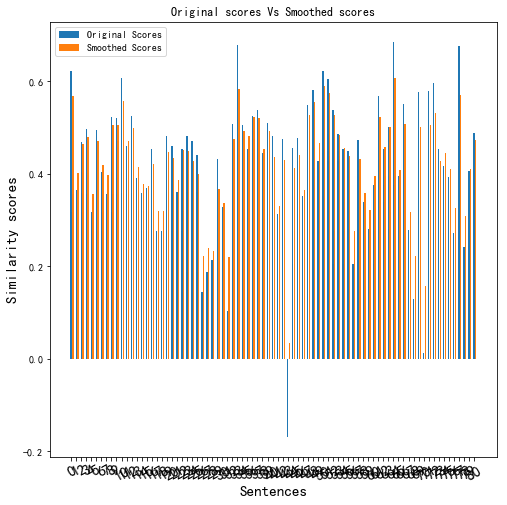

Abstract of this news is :
　　巨丰早评：市场将再次探底　　【巨丰观点】　　周四大盘冲高回落
　　金融股全线大涨：保险板块涨3%：新华保险、中国太保、中国人寿涨4%
　　天信投资：尾盘跳水原因揭秘伏击的品种曝光　　周四市场点评：　　沪深两市早盘纷纷低开
低矮动股指快速拉升
并顺势突破了60日均线和半年线的束缚；在主板拉升的过程中
形成长长的上影线；而创业板股指在回落的过程中失守5日均线的支撑
整体上周四市场全天保持宽幅震荡走势
保险、银行、中字头、举牌等品种涨幅居前；钛金属、区块链、雄安新区、民营医院等品种领跌
　　今日市场预测：　　在周三收市的评论中
我们指出周四市场会出现阶段性的普涨行情
从三大股指周四呈现给大家的K线组合来看
　　短期行情判断：　　从大的环境上来看
因为目前无论是从宏观面、货币基本面或者从国际经济和政治的角度来看
　　周四市场沪指形成带长长上影线的倒锤阴线；创业板股指形成的是跌破5日和10日均线的中阴线
　　后市投资建议：　　短期建议投资者一定要控制好自身的仓位
The abstract contains: 15  splited sentences.
My program took 25.2731511592865 to run


In [29]:
start_time = time.time()

title='早间机构看市：市场将再次探底 两类股逢低布局'
content='?\r\n\u3000\u3000巨丰早评：市场将再次探底\r\n\u3000\u3000【巨丰观点】\r\n\u3000\u3000周四大盘冲高回落，2500余只个股下跌。上证50、沪深300指数顽强收红。早盘大盘低开高走，展开反弹，沪指冲破120日均线压力位；午后大盘跳水，个股普跌。盘面上，保险、电力、银行、民航机场、券商、房地产、人工智能、迪士尼、网络安全等板块涨幅居前。雄安新区、福州新区、医疗器械、丝绸之路等跌幅居前。\r\n\u3000\u3000金融股全线大涨：保险板块涨3%：新华保险、中国太保、中国人寿涨4%，中国平安涨2%；西水股份、天茂集团盘中大涨7%以上。银行板块涨2%：招商银行大涨8%，贵阳银行、兴业银行、浦发银行、兴业银行等涨幅居前。金融股是A股纳入MSCI指数的受益者，后市可以逢低关注。\r\n\u3000\u3000盘中万达电影、复星医药等白马股闪崩，导致午后市场出现大幅跳水。盘后消息，银监会于6月中旬要求各家银行排查包括万达、海航集团、复星、浙江罗森内里在内数家企业的授信及风险分析，排查对象多是近年来海外投资比较凶猛、在银行业敞口较大的民营企业集团。\r\n\u3000\u3000巨丰投顾认为自5月以来，大盘已经走出了3重底的走势，并开启中级反弹行情。沪指在上证50及白马股推动下率先反弹，但遭遇60日、120日均线强压力而出现调整。MSCI纳入A股后，沪深300指数创17个月新高，但2500余股下跌，市场分化明显。随着6月末市场流动性紧张的可能出现，市场将再次出现探底。建议投资者重点关注半年报大幅预增的错杀股和具备估值优势的大蓝筹。\r\n\u3000\u3000天信投资：尾盘跳水原因揭秘 伏击的品种曝光\r\n\u3000\u3000周四市场点评：\r\n\u3000\u3000沪深两市早盘纷纷低开，但是开盘之后权重板块崛起，其中保险和银行表现尤其明显，低矮动股指快速拉升，并顺势突破了60日均线和半年线的束缚；在主板拉升的过程中，市场的分化格局也较明显，题材板块和创业板表现相对较弱。不过虽然市场在早盘的上攻，但是成交量萎缩明教明显，所以这种上涨比较虚。果不其然，午后个股再度纷纷杀跌，同时股指也是顺势回落，沪市的半年线得而复失，形成长长的上影线；而创业板股指在回落的过程中失守5日均线的支撑。整体上周四市场全天保持宽幅震荡走势，尤其是沪市冲高回落。保险、银行、中字头、举牌等品种涨幅居前；钛金属、区块链、雄安新区、民营医院等品种领跌。\r\n\u3000\u3000今日市场预测：\r\n\u3000\u3000在周三收市的评论中，我们指出周四市场会出现阶段性的普涨行情，而周四早盘三大股指齐齐上涨，即使创业板股指涨幅较小，但是市场确实也给我们呈现的普涨格局。但是午后的跳水，包括创业板股指先下跌，随后沪指尾盘的快速下杀，使得市场从普涨瞬间到普跌，市场的大起大落来的非常刺激。从三大股指周四呈现给大家的K线组合来看，预计今日市场齐跌的概率较大，不过创业板合格题材板块或具备一定的抗跌性。\r\n\u3000\u3000短期行情判断：\r\n\u3000\u3000从大的环境上来看，市场目前本身不具备大面积和大空间的反弹基础，因为目前无论是从宏观面、货币基本面或者从国际经济和政治的角度来看，都不具备这样的条件，所以反应到市场中来，只能是结构性、局部性的投机性机会。而最近半个月以来，市场的走势也确实符合局部性、结构性投机的走势。\r\n\u3000\u3000周四市场沪指形成带长长上影线的倒锤阴线；创业板股指形成的是跌破5日和10日均线的中阴线，这种类型的K线形态，几乎都是市场开始调整的先兆，所以短期市场而言，悲观的情绪或升温。\r\n\u3000\u3000后市投资建议：\r\n\u3000\u3000短期建议投资者一定要控制好自身的仓位。中期继续看好题材板块的崛起，特别是次新股、高送转、重组股等等可以不断的去伏击，依旧具备超跌反弹的性质。\r\n'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.3,weightpara=1e-5, language='Chinese')

print ("My program took", time.time() - start_time, "to run")

### Test Case 3 based on Model 2:
#### case 3-1:
pct_keep=0.3<br>
weightpara = 1e-3 <br>
n_neigbors=3<br>

Title is: U23之光！国安小将中超首秀助攻奥古 抽筋后获球迷掌声 

Content is : 凤凰体育讯（记者刘璐莎）今晚，中超联赛在间歇期后重燃战火，刚刚完成换帅的北京中赫国安主场迎战天津忆利。代理主教练谢峰在首发阵容上进行大幅调整，U23球员巴顿首发登场，前12轮均首发的唐诗被安排在替补席上。第60分钟，巴顿助攻奥古斯托将场上比分改写为2-0。巴顿上一轮国安客场不敌重庆力帆后，主教练何塞下课，国安紧锣密鼓寻找新帅。目前，新帅人选已经确定为施密特，不过施密特未来到球队前，国安由谢峰等中方教练组代理过渡。本场比赛，谢峰对首发阵容进行大幅调整，张稀哲和李翰博由于红牌停赛，于大宝继续伤停，伊尔马兹和索里亚诺的“伊索”组合搭档双前锋，而前12轮均首发的U23球员唐诗被安排在替补席上，此前鲜少进入大名单的巴顿首发出场。这是巴顿的中超首秀，上半场他的触球机会并不多，第20分钟，一次左路拿球传中，伊尔马兹接球后射门皮球高出球门。下半场巴顿继续留在场上，第61分钟，巴顿右路传中，奥古斯托轻推远角射门，在伊尔马斯上半场的进球后，将场上比分改写为2-0。巴顿的中超首秀迎来的球迷的肯定。第78分钟，拼尽全力的巴顿体力不支，抽筋倒在场地中，工体近3万球迷高喊着巴顿的名字。 

There are  40 sentences been splited and need embeddings.
Word map finished
word2weight finished
weight4ind finished 
sentences2idx finished 
seq2weight finished 
embedding start 
emb shape: (42, 100)
PCA used for decompostion PCA(copy=True, iterated_power='auto', n_components=1, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)
embedding finished 
(42, 100)


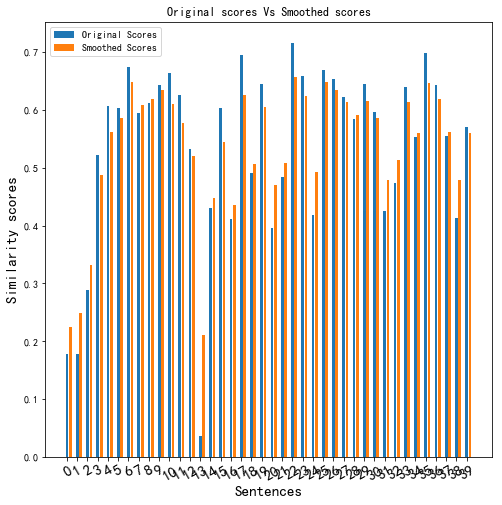

Abstract of this news is :
U23球员巴顿首发登场
巴顿助攻奥古斯托将场上比分改写为2-0
本场比赛
而前12轮均首发的U23球员唐诗被安排在替补席上
此前鲜少进入大名单的巴顿首发出场
上半场他的触球机会并不多
第20分钟
巴顿的中超首秀迎来的球迷的肯定
The abstract contains: 8  splited sentences.
My program took 25.441767930984497 to run


In [31]:
start_time = time.time()

title='U23之光！国安小将中超首秀助攻奥古 抽筋后获球迷掌声'
content='凤凰体育讯（记者刘璐莎）今晚，中超联赛在间歇期后重燃战火，刚刚完成换帅的北京中赫国安主场迎战天津忆利。代理主教练谢峰在首发阵容上进行大幅调整，U23球员巴顿首发登场，前12轮均首发的唐诗被安排在替补席上。第60分钟，巴顿助攻奥古斯托将场上比分改写为2-0。\r\n巴顿\r\n上一轮国安客场不敌重庆力帆后，主教练何塞下课，国安紧锣密鼓寻找新帅。目前，新帅人选已经确定为施密特，不过施密特未来到球队前，国安由谢峰等中方教练组代理过渡。本场比赛，谢峰对首发阵容进行大幅调整，张稀哲和李翰博由于红牌停赛，于大宝继续伤停，伊尔马兹和索里亚诺的“伊索”组合搭档双前锋，而前12轮均首发的U23球员唐诗被安排在替补席上，此前鲜少进入大名单的巴顿首发出场。\r\n这是巴顿的中超首秀，上半场他的触球机会并不多，第20分钟，一次左路拿球传中，伊尔马兹接球后射门皮球高出球门。下半场巴顿继续留在场上，第61分钟，巴顿右路传中，奥古斯托轻推远角射门，在伊尔马斯上半场的进球后，将场上比分改写为2-0。\r\n巴顿的中超首秀迎来的球迷的肯定。第78分钟，拼尽全力的巴顿体力不支，抽筋倒在场地中，工体近3万球迷高喊着巴顿的名字。'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.2,weightpara = 1e-3,language='Chinese')

print ("My program took", time.time() - start_time, "to run")

#### case 3-2:
pct_keep=0.3<br>
weightpara = 1e-5 <br>
n_neigbors=3<br>

Title is: U23之光！国安小将中超首秀助攻奥古 抽筋后获球迷掌声 

Content is : 凤凰体育讯（记者刘璐莎）今晚，中超联赛在间歇期后重燃战火，刚刚完成换帅的北京中赫国安主场迎战天津忆利。代理主教练谢峰在首发阵容上进行大幅调整，U23球员巴顿首发登场，前12轮均首发的唐诗被安排在替补席上。第60分钟，巴顿助攻奥古斯托将场上比分改写为2-0。巴顿上一轮国安客场不敌重庆力帆后，主教练何塞下课，国安紧锣密鼓寻找新帅。目前，新帅人选已经确定为施密特，不过施密特未来到球队前，国安由谢峰等中方教练组代理过渡。本场比赛，谢峰对首发阵容进行大幅调整，张稀哲和李翰博由于红牌停赛，于大宝继续伤停，伊尔马兹和索里亚诺的“伊索”组合搭档双前锋，而前12轮均首发的U23球员唐诗被安排在替补席上，此前鲜少进入大名单的巴顿首发出场。这是巴顿的中超首秀，上半场他的触球机会并不多，第20分钟，一次左路拿球传中，伊尔马兹接球后射门皮球高出球门。下半场巴顿继续留在场上，第61分钟，巴顿右路传中，奥古斯托轻推远角射门，在伊尔马斯上半场的进球后，将场上比分改写为2-0。巴顿的中超首秀迎来的球迷的肯定。第78分钟，拼尽全力的巴顿体力不支，抽筋倒在场地中，工体近3万球迷高喊着巴顿的名字。 

There are  40 sentences been splited and need embeddings.
Word map finished
word2weight finished
weight4ind finished 
sentences2idx finished 
seq2weight finished 
embedding start 
emb shape: (42, 100)
PCA used for decompostion PCA(copy=True, iterated_power='auto', n_components=1, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)
embedding finished 
(42, 100)


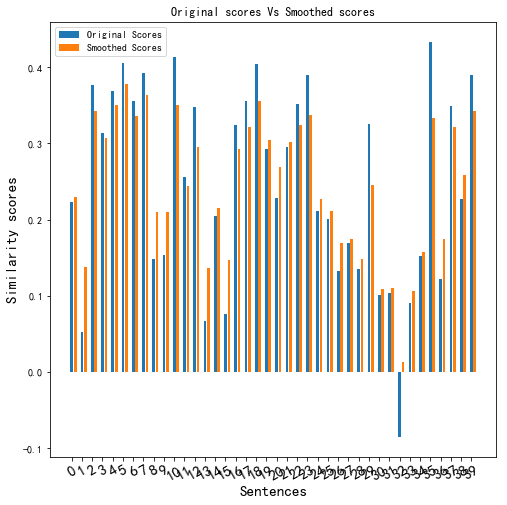

Abstract of this news is :
今晚
刚刚完成换帅的北京中赫国安主场迎战天津忆利
代理主教练谢峰在首发阵容上进行大幅调整
前12轮均首发的唐诗被安排在替补席上
巴顿上一轮国安客场不敌重庆力帆后
谢峰对首发阵容进行大幅调整
此前鲜少进入大名单的巴顿首发出场
工体近3万球迷高喊着巴顿的名字
The abstract contains: 8  splited sentences.
My program took 24.362192153930664 to run


In [36]:
start_time = time.time()

title='U23之光！国安小将中超首秀助攻奥古 抽筋后获球迷掌声'
content='凤凰体育讯（记者刘璐莎）今晚，中超联赛在间歇期后重燃战火，刚刚完成换帅的北京中赫国安主场迎战天津忆利。代理主教练谢峰在首发阵容上进行大幅调整，U23球员巴顿首发登场，前12轮均首发的唐诗被安排在替补席上。第60分钟，巴顿助攻奥古斯托将场上比分改写为2-0。\r\n巴顿\r\n上一轮国安客场不敌重庆力帆后，主教练何塞下课，国安紧锣密鼓寻找新帅。目前，新帅人选已经确定为施密特，不过施密特未来到球队前，国安由谢峰等中方教练组代理过渡。本场比赛，谢峰对首发阵容进行大幅调整，张稀哲和李翰博由于红牌停赛，于大宝继续伤停，伊尔马兹和索里亚诺的“伊索”组合搭档双前锋，而前12轮均首发的U23球员唐诗被安排在替补席上，此前鲜少进入大名单的巴顿首发出场。\r\n这是巴顿的中超首秀，上半场他的触球机会并不多，第20分钟，一次左路拿球传中，伊尔马兹接球后射门皮球高出球门。下半场巴顿继续留在场上，第61分钟，巴顿右路传中，奥古斯托轻推远角射门，在伊尔马斯上半场的进球后，将场上比分改写为2-0。\r\n巴顿的中超首秀迎来的球迷的肯定。第78分钟，拼尽全力的巴顿体力不支，抽筋倒在场地中，工体近3万球迷高喊着巴顿的名字。'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.2,weightpara = 1e-5,language='Chinese')

print ("My program took", time.time() - start_time, "to run")

### Test Case 4 based on Model 2:
#### case 4-1:
pct_keep=0.2<br>
weightpara = 1e-3 <br>
n_neigbors=3<br>

Title is: 格力手机2 - 年初2400都买不到 现1200没人要 

Content is : 这也导致到目前为止这部新机只售出2000多台，评价也只有寥寥几个，根据某自媒体14号的文章，当时这部手机的官网销量只有6台。就在大家都忍不住群嘲格力凭什么千元机的配置卖出中端机价格的时候。董大姐谈到格力手机的时候仍然力挺，认为出了有点贵之外，谁用谁说好，你们不识货。这让我们不禁想起了新手机色界的大哥——格力手机2代。这部凝聚了格力和董明珠颇多心血的产品，实现了董大姐之前要卖5000万部的豪言了吗?于斌到格力的官网上围观了一下，这部手机的金色版截止到发稿前官网显示售出不到2万部，客户评价数量只有89个。而价格即使在半年之后，即使在整个网络都铺天盖地在进行618年中大促的情况下，仍然坚挺的保持在3599元一动不动，简直比苹果手机还保值。在同时间段，3000-4000元中间价位的手机，随便搜一搜就有很多不错的品牌和机型。可以看到华为的P10，Mate9，荣耀V9，vivoX9Plus，三星S7，OPPOR9sPlus，这些都是差不多价位的手机。不管是从品牌知名度和机型成熟度，配置还是工业设计，都全方位的“吊打”至今只出了3部手机，整体来说还不成熟的格力手机。所以即使格力对自己的手机产品保持200%的自信，坚持不降价，残酷的市场现实却是用脚投票的。在格力手机2代正式上市之前，这部手机在市场上就已经折价到2400元不到，闲鱼等二手交易平台曾经一夜冒出多个卖家出售格力手机2代，价格多为两千元左右，最后更有甚者压价到1800元出售，最后的成交仍然寥寥。这件事在科技媒体闹的沸沸扬扬，网传低价转让格力手机的是格力内部员工，因为不满意这个手机“年终奖”而去变现，还引来了格力官方的否认澄清，又有传闻卖家是格力的供应商，但是也没有最终实锤，相信大家应该还有记忆。这件事一度取代了开机屏图片将会强制设置成格力董事长董明珠的肖像，成为外界对格力手机的最大关注点。最终在这件事的影响下，格力手机2代并没有大面积铺货，总体销量至今官方还没有公布一个具体的数字。但是据微博大V爆料，靠着内部渠道，格力手机2代就已经卖了小几十万。并且揭秘格力的骁龙835项目也在进行中，格力已经建立了小几百人的手机团队，投入金额几个亿。难怪格力对于官方商城和其他电商渠道和其他品牌相比悬殊的差距销售数字并不着急，对于手机的

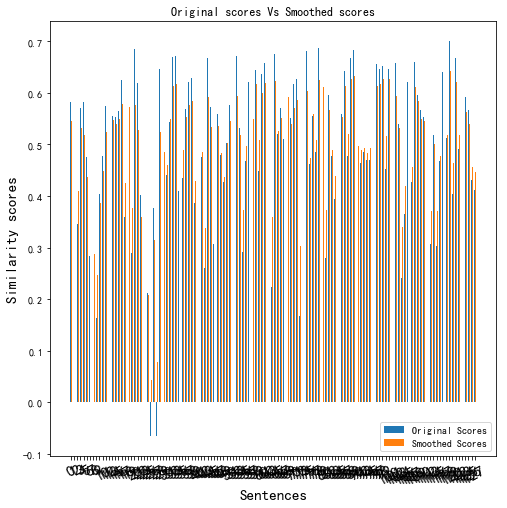

Abstract of this news is :
整体来说还不成熟的格力手机
所以即使格力对自己的手机产品保持200%的自信
格力已经建立了小几百人的手机团队
对于手机的售价在过去半年之后仍然巍然不动
格力手机2代在闲鱼上的二手价格在持续下跌中
格力进入国内手机市场的时间太晚
而格力不管是在品牌建设还是在手机产品软硬件上
从现在格力手机和几大国产手机品牌的销量对比就能够看出
格力手机在手机市场现在基本上没有竞争力可言
格力手机甚至还没有找准自身的定位
仅仅依靠内部渠道就消化了几十万部手机的业绩
现在看可能是侧面证明了格力通过空调等家电建立的经销商分销商体系的成功
这也证明了格力手机市场推广和渠道资源十分有限
尽管格力在手机这个业务上
但是国内的手机市场门槛和前几年相比已经跨越式升级
The abstract contains: 15  splited sentences.
My program took 26.512871980667114 to run


In [37]:
import time
start_time = time.time()

title='格力手机2 - 年初2400都买不到 现1200没人要'
content='这也导致到目前为止这部新机只售出2000多台，评价也只有寥寥几个，根据某自媒体14号的文章，当时这部手机的官网销量只有6台。\r\n就在大家都忍不住群嘲格力凭什么千元机的配置卖出中端机价格的时候。董大姐谈到格力手机的时候仍然力挺，认为出了有点贵之外，谁用谁说好，你们不识货。这让我们不禁想起了新手机色界的大哥——格力手机2代。这部凝聚了格力和董明珠颇多心血的产品，实现了董大姐之前要卖5000万部的豪言了吗?\r\n于斌到格力的官网上围观了一下，这部手机的金色版截止到发稿前官网显示售出不到2万部，客户评价数量只有89个。而价格即使在半年之后，即使在整个网络都铺天盖地在进行618年中大促的情况下，仍然坚挺的保持在3599元一动不动，简直比苹果手机还保值。\r\n在同时间段，3000-4000元中间价位的手机，随便搜一搜就有很多不错的品牌和机型。可以看到华为的P10，Mate9，荣耀V9，vivo X9Plus，三星S7，OPPO R9s Plus，这些都是差不多价位的手机。不管是从品牌知名度和机型成熟度，配置还是工业设计，都全方位的“吊打”至今只出了3部手机，整体来说还不成熟的格力手机。\r\n所以即使格力对自己的手机产品保持200%的自信，坚持不降价，残酷的市场现实却是用脚投票的。在格力手机2代正式上市之前，这部手机在市场上就已经折价到2400元不到，闲鱼等二手交易平台曾经一夜冒出多个卖家出售格力手机2代，价格多为两千元左右，最后更有甚者压价到1800元出售，最后的成交仍然寥寥。\r\n这件事在科技媒体闹的沸沸扬扬，网传低价转让格力手机的是格力内部员工，因为不满意这个手机“年终奖”而去变现，还引来了格力官方的否认澄清，又有传闻卖家是格力的供应商，但是也没有最终实锤，相信大家应该还有记忆。这件事一度取代了开机屏图片将会强制设置成格力董事长董明珠的肖像，成为外界对格力手机的最大关注点。\r\n最终在这件事的影响下，格力手机2代并没有大面积铺货，总体销量至今官方还没有公布一个具体的数字。但是据微博大V爆料，靠着内部渠道，格力手机2代就已经卖了小几十万。并且揭秘格力的骁龙835项目也在进行中，格力已经建立了小几百人的手机团队，投入金额几个亿。\r\n难怪格力对于官方商城和其他电商渠道和其他品牌相比悬殊的差距销售数字并不着急，对于手机的售价在过去半年之后仍然巍然不动，显然对于自身的经销商渠道和内部消化能力非常自信。\r\n不过与此同时，格力手机2代在闲鱼上的二手价格在持续下跌中。从原本最初的2000多元的价位，到目前九成新的机器，报价1100-1200元不等，而大部分挂出来的二手格力手机的单子，基本没有用户留言咨询。官网上坚持的原价和二手平台上持续下跌的价格，1200以下降价近2/3也没有人关注，形成了鲜明的对比。\u3000\u3000\r\n大概在这两年，董大姐想要实现手机售卖超过5000万台，“华为卖第一我们就卖第二”的远大抱负，几乎是不可能完成的任务。\r\n之前于斌就分析过，格力进入国内手机市场的时间太晚，现在的市场已经没有多少增量红利可以蹭了。现在的国产手机品牌中排名靠前的华为、OPPO、Vivo、小米、中兴，这些出货量靠前的品牌都有一个共通点，都是快速崛起在中国的智能手机市场爆发式增长时期，是在还有增量红利的时期起来的。而现在整个中国市场已经全面进入换机市场，用户换机更加看重品牌和手机使用体验。而格力不管是在品牌建设还是在手机产品软硬件上，都比不上已经深耕市场多年的华为、OV等品牌。\r\n从现在格力手机和几大国产手机品牌的销量对比就能够看出，格力手机在手机市场现在基本上没有竞争力可言。在性价比上没有优势，在产品的工业设计上，也没办法讨好“颜值即是正义”的用户。对比起华为主打中高端商务市场，OV主打拍照功能深耕女性市场，小米面向年轻人这样明确的路线，格力手机甚至还没有找准自身的定位。\r\n仅仅依靠内部渠道就消化了几十万部手机的业绩，现在看可能是侧面证明了格力通过空调等家电建立的经销商分销商体系的成功。但是从另一个角度来看，这也证明了格力手机市场推广和渠道资源十分有限。在外部电商渠道上，格力手机全网貌似仅有京东在售，并且销量甚至比不上官方商城，成绩惨淡。目前来看，格力的销售转化更多的是依靠内部渠道，，之前媒体也报道过，在其产能稳定后还会在格力线下专卖店销售，格力空调在各地销售公司会向经销商少量地“摊派”出售。但是这样的摊派模式在产品畅销的情况下好说，一旦产品出现滞销卖不动的情况，对于地下的经销商来说，就是负担了，这个模式不是一个可持续的健康模式。显然，到手之后就只值一半钱，并且还在不断的折价下跌的格力手机，还不能够算是一款畅销的产品。\r\n尽管格力在手机这个业务上，大手笔的投入了几个亿来搞，但是国内的手机市场门槛和前几年相比已经跨越式升级。和华为、OV动辄投放几个亿来推一个新品，砸综艺请明星全渠道营销的手笔相比，格力的动作可能只能借着此前空调积累下的名声在媒体圈激起一点点小水花，但是在真刀真枪的市场上，没有体系化建立研发、销售和售后等布局的格力，显然十分被动。\r\n'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.2,weightpara = 1e-3 ,language='Chinese')

print ("My program took", time.time() - start_time, "to run")

#### case 4-2:
pct_keep=0.2<br>
weightpara = 1e-5 <br>
n_neigbors=3<br>

Title is: 格力手机2 - 年初2400都买不到 现1200没人要 

Content is : 这也导致到目前为止这部新机只售出2000多台，评价也只有寥寥几个，根据某自媒体14号的文章，当时这部手机的官网销量只有6台。就在大家都忍不住群嘲格力凭什么千元机的配置卖出中端机价格的时候。董大姐谈到格力手机的时候仍然力挺，认为出了有点贵之外，谁用谁说好，你们不识货。这让我们不禁想起了新手机色界的大哥——格力手机2代。这部凝聚了格力和董明珠颇多心血的产品，实现了董大姐之前要卖5000万部的豪言了吗?于斌到格力的官网上围观了一下，这部手机的金色版截止到发稿前官网显示售出不到2万部，客户评价数量只有89个。而价格即使在半年之后，即使在整个网络都铺天盖地在进行618年中大促的情况下，仍然坚挺的保持在3599元一动不动，简直比苹果手机还保值。在同时间段，3000-4000元中间价位的手机，随便搜一搜就有很多不错的品牌和机型。可以看到华为的P10，Mate9，荣耀V9，vivoX9Plus，三星S7，OPPOR9sPlus，这些都是差不多价位的手机。不管是从品牌知名度和机型成熟度，配置还是工业设计，都全方位的“吊打”至今只出了3部手机，整体来说还不成熟的格力手机。所以即使格力对自己的手机产品保持200%的自信，坚持不降价，残酷的市场现实却是用脚投票的。在格力手机2代正式上市之前，这部手机在市场上就已经折价到2400元不到，闲鱼等二手交易平台曾经一夜冒出多个卖家出售格力手机2代，价格多为两千元左右，最后更有甚者压价到1800元出售，最后的成交仍然寥寥。这件事在科技媒体闹的沸沸扬扬，网传低价转让格力手机的是格力内部员工，因为不满意这个手机“年终奖”而去变现，还引来了格力官方的否认澄清，又有传闻卖家是格力的供应商，但是也没有最终实锤，相信大家应该还有记忆。这件事一度取代了开机屏图片将会强制设置成格力董事长董明珠的肖像，成为外界对格力手机的最大关注点。最终在这件事的影响下，格力手机2代并没有大面积铺货，总体销量至今官方还没有公布一个具体的数字。但是据微博大V爆料，靠着内部渠道，格力手机2代就已经卖了小几十万。并且揭秘格力的骁龙835项目也在进行中，格力已经建立了小几百人的手机团队，投入金额几个亿。难怪格力对于官方商城和其他电商渠道和其他品牌相比悬殊的差距销售数字并不着急，对于手机的

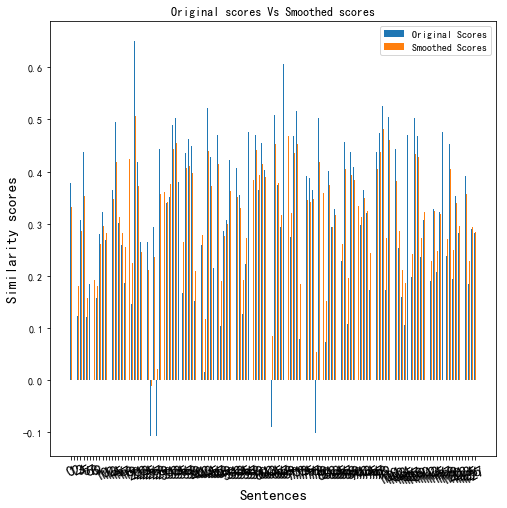

Abstract of this news is :
3000-4000元中间价位的手机
整体来说还不成熟的格力手机
所以即使格力对自己的手机产品保持200%的自信
网传低价转让格力手机的是格力内部员工
格力已经建立了小几百人的手机团队
显然对于自身的经销商渠道和内部消化能力非常自信
格力手机2代在闲鱼上的二手价格在持续下跌中
报价1100-1200元不等
而大部分挂出来的二手格力手机的单子
官网上坚持的原价和二手平台上持续下跌的价格
1200以下降价近2/3也没有人关注
仅仅依靠内部渠道就消化了几十万部手机的业绩
现在看可能是侧面证明了格力通过空调等家电建立的经销商分销商体系的成功
这也证明了格力手机市场推广和渠道资源十分有限
在其产能稳定后还会在格力线下专卖店销售
The abstract contains: 15  splited sentences.
My program took 26.29987621307373 to run


In [39]:
import time
start_time = time.time()

title='格力手机2 - 年初2400都买不到 现1200没人要'
content='这也导致到目前为止这部新机只售出2000多台，评价也只有寥寥几个，根据某自媒体14号的文章，当时这部手机的官网销量只有6台。\r\n就在大家都忍不住群嘲格力凭什么千元机的配置卖出中端机价格的时候。董大姐谈到格力手机的时候仍然力挺，认为出了有点贵之外，谁用谁说好，你们不识货。这让我们不禁想起了新手机色界的大哥——格力手机2代。这部凝聚了格力和董明珠颇多心血的产品，实现了董大姐之前要卖5000万部的豪言了吗?\r\n于斌到格力的官网上围观了一下，这部手机的金色版截止到发稿前官网显示售出不到2万部，客户评价数量只有89个。而价格即使在半年之后，即使在整个网络都铺天盖地在进行618年中大促的情况下，仍然坚挺的保持在3599元一动不动，简直比苹果手机还保值。\r\n在同时间段，3000-4000元中间价位的手机，随便搜一搜就有很多不错的品牌和机型。可以看到华为的P10，Mate9，荣耀V9，vivo X9Plus，三星S7，OPPO R9s Plus，这些都是差不多价位的手机。不管是从品牌知名度和机型成熟度，配置还是工业设计，都全方位的“吊打”至今只出了3部手机，整体来说还不成熟的格力手机。\r\n所以即使格力对自己的手机产品保持200%的自信，坚持不降价，残酷的市场现实却是用脚投票的。在格力手机2代正式上市之前，这部手机在市场上就已经折价到2400元不到，闲鱼等二手交易平台曾经一夜冒出多个卖家出售格力手机2代，价格多为两千元左右，最后更有甚者压价到1800元出售，最后的成交仍然寥寥。\r\n这件事在科技媒体闹的沸沸扬扬，网传低价转让格力手机的是格力内部员工，因为不满意这个手机“年终奖”而去变现，还引来了格力官方的否认澄清，又有传闻卖家是格力的供应商，但是也没有最终实锤，相信大家应该还有记忆。这件事一度取代了开机屏图片将会强制设置成格力董事长董明珠的肖像，成为外界对格力手机的最大关注点。\r\n最终在这件事的影响下，格力手机2代并没有大面积铺货，总体销量至今官方还没有公布一个具体的数字。但是据微博大V爆料，靠着内部渠道，格力手机2代就已经卖了小几十万。并且揭秘格力的骁龙835项目也在进行中，格力已经建立了小几百人的手机团队，投入金额几个亿。\r\n难怪格力对于官方商城和其他电商渠道和其他品牌相比悬殊的差距销售数字并不着急，对于手机的售价在过去半年之后仍然巍然不动，显然对于自身的经销商渠道和内部消化能力非常自信。\r\n不过与此同时，格力手机2代在闲鱼上的二手价格在持续下跌中。从原本最初的2000多元的价位，到目前九成新的机器，报价1100-1200元不等，而大部分挂出来的二手格力手机的单子，基本没有用户留言咨询。官网上坚持的原价和二手平台上持续下跌的价格，1200以下降价近2/3也没有人关注，形成了鲜明的对比。\u3000\u3000\r\n大概在这两年，董大姐想要实现手机售卖超过5000万台，“华为卖第一我们就卖第二”的远大抱负，几乎是不可能完成的任务。\r\n之前于斌就分析过，格力进入国内手机市场的时间太晚，现在的市场已经没有多少增量红利可以蹭了。现在的国产手机品牌中排名靠前的华为、OPPO、Vivo、小米、中兴，这些出货量靠前的品牌都有一个共通点，都是快速崛起在中国的智能手机市场爆发式增长时期，是在还有增量红利的时期起来的。而现在整个中国市场已经全面进入换机市场，用户换机更加看重品牌和手机使用体验。而格力不管是在品牌建设还是在手机产品软硬件上，都比不上已经深耕市场多年的华为、OV等品牌。\r\n从现在格力手机和几大国产手机品牌的销量对比就能够看出，格力手机在手机市场现在基本上没有竞争力可言。在性价比上没有优势，在产品的工业设计上，也没办法讨好“颜值即是正义”的用户。对比起华为主打中高端商务市场，OV主打拍照功能深耕女性市场，小米面向年轻人这样明确的路线，格力手机甚至还没有找准自身的定位。\r\n仅仅依靠内部渠道就消化了几十万部手机的业绩，现在看可能是侧面证明了格力通过空调等家电建立的经销商分销商体系的成功。但是从另一个角度来看，这也证明了格力手机市场推广和渠道资源十分有限。在外部电商渠道上，格力手机全网貌似仅有京东在售，并且销量甚至比不上官方商城，成绩惨淡。目前来看，格力的销售转化更多的是依靠内部渠道，，之前媒体也报道过，在其产能稳定后还会在格力线下专卖店销售，格力空调在各地销售公司会向经销商少量地“摊派”出售。但是这样的摊派模式在产品畅销的情况下好说，一旦产品出现滞销卖不动的情况，对于地下的经销商来说，就是负担了，这个模式不是一个可持续的健康模式。显然，到手之后就只值一半钱，并且还在不断的折价下跌的格力手机，还不能够算是一款畅销的产品。\r\n尽管格力在手机这个业务上，大手笔的投入了几个亿来搞，但是国内的手机市场门槛和前几年相比已经跨越式升级。和华为、OV动辄投放几个亿来推一个新品，砸综艺请明星全渠道营销的手笔相比，格力的动作可能只能借着此前空调积累下的名声在媒体圈激起一点点小水花，但是在真刀真枪的市场上，没有体系化建立研发、销售和售后等布局的格力，显然十分被动。\r\n'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.2,weightpara = 1e-5 ,language='Chinese')

print ("My program took", time.time() - start_time, "to run")

### Test cases for English using the word_vector and weight provided in the SIF paper

Title is: k-nearest neighbors algorithm  

Content is : In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression! In both cases, the input consists of the k closest training examples in the feature space! The output depends on whether k-NN is used for classification or regression: In k-NN classification, the output is a class membership, An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. The neighbors are taken from a set of objects for which the class (for k-NN classification) or the object property value (for k-NN regression) is known. This can be thought of as the training set for the algorithm, though no explicit training step is required, A peculiarity of the k-NN algorithm is tha

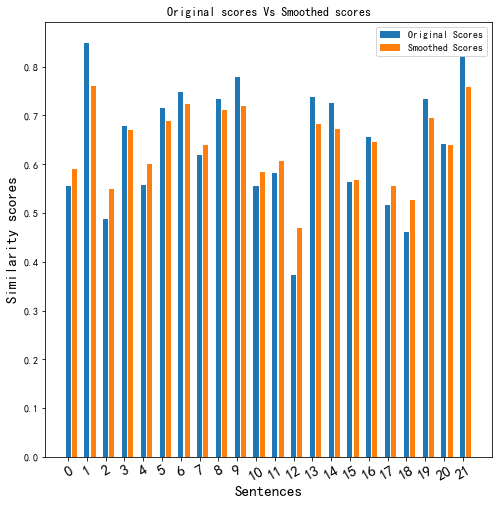

Abstract of this news is :
 the k-nearest neighbors algorithm 
 The output depends on whether k-NN is used for classification or regression: In k-NN classification
 An object is classified by a plurality vote of its neighbors
 with the object being assigned to the class most common among its k nearest neighbors 
 This can be thought of as the training set for the algorithm
 A peculiarity of the k-NN algorithm is that it is sensitive to the local structure of the data
The abstract contains: 6  splited sentences.
My program took 7.0386879444122314 to run


In [40]:
import time
start_time = time.time()
language='English'
title='k-nearest neighbors algorithm '
content='In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression! In both cases, the input consists of the k closest training examples in the feature space! The output depends on whether k-NN is used for classification or regression: In k-NN classification, the output is a class membership, An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. The neighbors are taken from a set of objects for which the class (for k-NN classification) or the object property value (for k-NN regression) is known. This can be thought of as the training set for the algorithm, though no explicit training step is required, A peculiarity of the k-NN algorithm is that it is sensitive to the local structure of the data.'
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.3, weightpara = 1e-3,language='english')

print ("My program took", time.time() - start_time, "to run")

Title is: World trade contracts as US-China trade war drags on 

Content is : The United States and China could still reach a phase one trade deal. That's the message for investors after top US and Chinese negotiators had a phone call late Monday (or Tuesday morning, Beijing time). What they talked about: Chinese Vice Premier Liu He, US Treasury Secretary Steven Mnuchin and Trade Representative Robert Lighthizer discussed core concerns and reached a consensus on how to resolve these issues, while agreeing to keep the conversation going, according to China's Commerce Ministry. That's the kind of update traders like to hear, especially as they worry about when the phase one deal promised last month will be completed, if ever.But it comes up against a less rosy development: global trade shrank 1.3% in September, according to the latest data from the CPB World Trade Monitor. That's a marked decline from August, when trade increased 0.5%.Timme Spakman, an economist at ING, points out that t

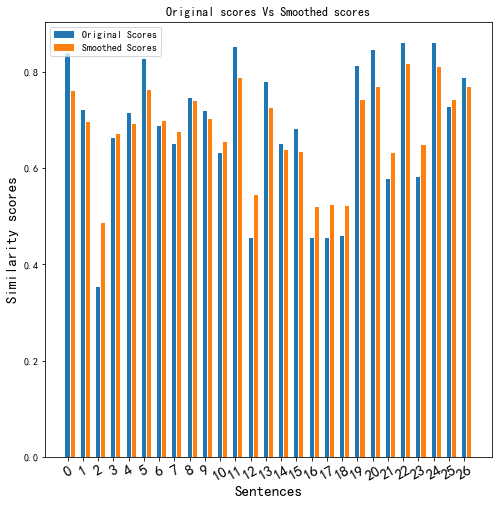

Abstract of this news is :
The United States and China could still reach a phase one trade deal
 US Treasury Secretary Steven Mnuchin and Trade Representative Robert Lighthizer discussed core concerns and reached a consensus on how to resolve these issues
But it comes up against a less rosy development: global trade shrank 1
 points out that this is concerning given that uncertainty on the trade front is far from over
 Trade tensions have slammed the brake on world trade growth in 2019
 While the trade war has directly affected trade flows between China and the US
 Societe Generale strategist Kit Juckes puts it bluntly: World trade is still not growing and will remain a drag on global GDP
 which has said it expects the trade drag to ease up in 2020
The abstract contains: 8  splited sentences.
My program took 6.497679948806763 to run


In [41]:
import time
start_time = time.time()
language='English'
title='World trade contracts as US-China trade war drags on'
content="The United States and China could still reach a phase one trade deal. That's the message for investors after top US and Chinese negotiators had a phone call late Monday (or Tuesday morning, Beijing time). What they talked about: Chinese Vice Premier Liu He, US Treasury Secretary Steven Mnuchin and Trade Representative Robert Lighthizer discussed core concerns and reached a consensus on how to resolve these issues, while agreeing to keep the conversation going, according to China's Commerce Ministry. That's the kind of update traders like to hear, especially as they worry about when the phase one deal promised last month will be completed, if ever.But it comes up against a less rosy development: global trade shrank 1.3% in September, according to the latest data from the CPB World Trade Monitor. That's a marked decline from August, when trade increased 0.5%.Timme Spakman, an economist at ING, points out that this is concerning given that uncertainty on the trade front is far from over. Trade tensions have slammed the brake on world trade growth in 2019, he wrote in a note to clients. While the trade war has directly affected trade flows between China and the US, the fallout has been widespread. Societe Generale strategist Kit Juckes puts it bluntly: World trade is still not growing and will remain a drag on global GDP. Remember: That sounds like a gloomier view than the one held by Goldman Sachs, which has said it expects the trade drag to ease up in 2020."
get_abstract(title, content,seperator = r'。|\，|\！|\……|\（|\）|\？|\.|\,|\!|\?|\(|\)', n_neigbors=3,pct_keep=0.3, weightpara = 1e-3,language='english')

print ("My program took", time.time() - start_time, "to run")

### Get test cases from news files

In [42]:
import pandas as pd
import re
df=pd.read_csv('../raw_data/sqlResult_1558435.csv',encoding='GB18030')
print (len(df))
df['title_content']=df.apply(lambda x: str(x['title']) + ' ' + str(x.content), axis=1)
df = df[pd.notnull(df['title_content'])]
print ('Remove observations that both content and title is null:', len(df))
print (len(df))
df['title_content']=df.apply(lambda x: x.title_content.replace('\r\n', ''), axis=1)
df['title_content'][0]

89611
Remove observations that both content and title is null: 89611
89611


'小米MIUI 9首批机型曝光：共计15款 此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。MIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI 9的确切信息，我们还是等待官方消息。'

In [43]:
df.tail()

,id,author,source,content,feature,title,url,title_content
89606,5,邹峥,新华社,新华社照片，多伦多，2017年6月7日\n（体育）（2）冰球——国家女子冰球队海外选秀在多伦...,"{""type"":""冰球"",""site"":""新华社"",""url"":""http://home.x...",（体育）（2）冰球——国家女子冰球队海外选秀在多伦多展开,http://home.xinhua-news.com/gdsdetailxhsnew/22...,（体育）（2）冰球——国家女子冰球队海外选秀在多伦多展开 新华社照片，多伦多，2017年6月...
89607,4,王衡,新华社,新华社兰州6月3日电（王衡、徐丹）记者从甘肃省交通运输厅获悉，甘肃近日集中开建高速公路、普通...,"{""type"":""宏观经济"",""site"":""新华社"",""url"":""http://home...",（经济）甘肃集中开工35个重点交通建设项目,http://home.xinhua-news.com/gdsdetailxhsnew/22...,（经济）甘肃集中开工35个重点交通建设项目 新华社兰州6月3日电（王衡、徐丹）记者从甘肃省交...
89608,3,张旌,新华社,\n\n2017年5月29日，在法国巴黎郊外的凡尔赛宫，法国总统马克龙出席新闻发布会。（新华...,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",法国议会选举 马克龙有望获“压倒性胜利”,http://home.xinhua-news.com/gdsdetailxhsnew/22...,法国议会选举 马克龙有望获“压倒性胜利” \n\n2017年5月29日，在法国巴黎郊外的凡尔...
89609,2,夏文辉,新华社,\n\n2017年5月25日，在美国马萨诸塞州剑桥市，哈佛大学毕业生在毕业典礼上欢呼。（新华...,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",哈佛大学为何取消这些新生入选资格？,http://home.xinhua-news.com/gdsdetailxhsnew/22...,哈佛大学为何取消这些新生入选资格？ \n\n2017年5月25日，在美国马萨诸塞州剑桥市，哈...
89610,1,王子江 张寒,新华社,新华社德国杜塞尔多夫６月６日电题：乒乓女球迷 \n 新华社记者王子江、张寒\n 熊老...,"{""type"":""体育"",""site"":""新华社"",""url"":""http://home.x...",（体育）题：乒乓女球迷,http://home.xinhua-news.com/gdsdetailxhsnew/22...,（体育）题：乒乓女球迷 新华社德国杜塞尔多夫６月６日电题：乒乓女球迷 \n 新华社记...


In [24]:
df['title'][11]

'早间机构看市：市场将再次探底 两类股逢低布局'

In [25]:
df['content'][11]

'?\r\n\u3000\u3000巨丰早评：市场将再次探底\r\n\u3000\u3000【巨丰观点】\r\n\u3000\u3000周四大盘冲高回落，2500余只个股下跌。上证50、沪深300指数顽强收红。早盘大盘低开高走，展开反弹，沪指冲破120日均线压力位；午后大盘跳水，个股普跌。盘面上，保险、电力、银行、民航机场、券商、房地产、人工智能、迪士尼、网络安全等板块涨幅居前。雄安新区、福州新区、医疗器械、丝绸之路等跌幅居前。\r\n\u3000\u3000金融股全线大涨：保险板块涨3%：新华保险、中国太保、中国人寿涨4%，中国平安涨2%；西水股份、天茂集团盘中大涨7%以上。银行板块涨2%：招商银行大涨8%，贵阳银行、兴业银行、浦发银行、兴业银行等涨幅居前。金融股是A股纳入MSCI指数的受益者，后市可以逢低关注。\r\n\u3000\u3000盘中万达电影、复星医药等白马股闪崩，导致午后市场出现大幅跳水。盘后消息，银监会于6月中旬要求各家银行排查包括万达、海航集团、复星、浙江罗森内里在内数家企业的授信及风险分析，排查对象多是近年来海外投资比较凶猛、在银行业敞口较大的民营企业集团。\r\n\u3000\u3000巨丰投顾认为自5月以来，大盘已经走出了3重底的走势，并开启中级反弹行情。沪指在上证50及白马股推动下率先反弹，但遭遇60日、120日均线强压力而出现调整。MSCI纳入A股后，沪深300指数创17个月新高，但2500余股下跌，市场分化明显。随着6月末市场流动性紧张的可能出现，市场将再次出现探底。建议投资者重点关注半年报大幅预增的错杀股和具备估值优势的大蓝筹。\r\n\u3000\u3000天信投资：尾盘跳水原因揭秘 伏击的品种曝光\r\n\u3000\u3000周四市场点评：\r\n\u3000\u3000沪深两市早盘纷纷低开，但是开盘之后权重板块崛起，其中保险和银行表现尤其明显，低矮动股指快速拉升，并顺势突破了60日均线和半年线的束缚；在主板拉升的过程中，市场的分化格局也较明显，题材板块和创业板表现相对较弱。不过虽然市场在早盘的上攻，但是成交量萎缩明教明显，所以这种上涨比较虚。果不其然，午后个股再度纷纷杀跌，同时股指也是顺势回落，沪市的半年线得而复失，形成长长的上影线；而创业板股指在回落的过程中失守5日均线的支撑。整体上周四市场全天保持宽幅震荡走势，尤其是沪

In [42]:
df['title'][91]

'格力手机2 - 年初2400都买不到 现1200没人要'

In [43]:
df['content'][91]

'这也导致到目前为止这部新机只售出2000多台，评价也只有寥寥几个，根据某自媒体14号的文章，当时这部手机的官网销量只有6台。\r\n就在大家都忍不住群嘲格力凭什么千元机的配置卖出中端机价格的时候。董大姐谈到格力手机的时候仍然力挺，认为出了有点贵之外，谁用谁说好，你们不识货。这让我们不禁想起了新手机色界的大哥——格力手机2代。这部凝聚了格力和董明珠颇多心血的产品，实现了董大姐之前要卖5000万部的豪言了吗?\r\n于斌到格力的官网上围观了一下，这部手机的金色版截止到发稿前官网显示售出不到2万部，客户评价数量只有89个。而价格即使在半年之后，即使在整个网络都铺天盖地在进行618年中大促的情况下，仍然坚挺的保持在3599元一动不动，简直比苹果手机还保值。\r\n在同时间段，3000-4000元中间价位的手机，随便搜一搜就有很多不错的品牌和机型。可以看到华为的P10，Mate9，荣耀V9，vivo X9Plus，三星S7，OPPO R9s Plus，这些都是差不多价位的手机。不管是从品牌知名度和机型成熟度，配置还是工业设计，都全方位的“吊打”至今只出了3部手机，整体来说还不成熟的格力手机。\r\n所以即使格力对自己的手机产品保持200%的自信，坚持不降价，残酷的市场现实却是用脚投票的。在格力手机2代正式上市之前，这部手机在市场上就已经折价到2400元不到，闲鱼等二手交易平台曾经一夜冒出多个卖家出售格力手机2代，价格多为两千元左右，最后更有甚者压价到1800元出售，最后的成交仍然寥寥。\r\n这件事在科技媒体闹的沸沸扬扬，网传低价转让格力手机的是格力内部员工，因为不满意这个手机“年终奖”而去变现，还引来了格力官方的否认澄清，又有传闻卖家是格力的供应商，但是也没有最终实锤，相信大家应该还有记忆。这件事一度取代了开机屏图片将会强制设置成格力董事长董明珠的肖像，成为外界对格力手机的最大关注点。\r\n最终在这件事的影响下，格力手机2代并没有大面积铺货，总体销量至今官方还没有公布一个具体的数字。但是据微博大V爆料，靠着内部渠道，格力手机2代就已经卖了小几十万。并且揭秘格力的骁龙835项目也在进行中，格力已经建立了小几百人的手机团队，投入金额几个亿。\r\n难怪格力对于官方商城和其他电商渠道和其他品牌相比悬殊的差距销售数字并不着急，对于手机的售价在过去半年之后仍然巍然不动，显然对于自

In [1]:
len(': 此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI9的研发之中。MIUI8去年5月发布，距今已有一年有余，也是时候更新换代了。当然，关于MIUI9的确切信息，我们还是等待官方消息。')

170

In [2]:
len('巨丰早评：市场将再次探底　　【巨丰观点】　　周四大盘冲高回落，2500余只个股下跌。上证50、沪深300指数顽强收红。早盘大盘低开高走，展开反弹，沪指冲破120日均线压力位；午后大盘跳水，个股普跌。盘面上，保险、电力、银行、民航机场、券商、房地产、人工智能、迪士尼、网络安全等板块涨幅居前。雄安新区、福州新区、医疗器械、丝绸之路等跌幅居前。　　金融股全线大涨：保险板块涨3%：新华保险、中国太保、中国人寿涨4%，中国平安涨2%；西水股份、天茂集团盘中大涨7%以上。银行板块涨2%：招商银行大涨8%，贵阳银行、兴业银行、浦发银行、兴业银行等涨幅居前。金融股是A股纳入MSCI指数的受益者，后市可以逢低关注。　　盘中万达电影、复星医药等白马股闪崩，导致午后市场出现大幅跳水。盘后消息，银监会于6月中旬要求各家银行排查包括万达、海航集团、复星、浙江罗森内里在内数家企业的授信及风险分析，排查对象多是近年来海外投资比较凶猛、在银行业敞口较大的民营企业集团。　　巨丰投顾认为自5月以来，大盘已经走出了3重底的走势，并开启中级反弹行情。沪指在上证50及白马股推动下率先反弹，但遭遇60日、120日均线强压力而出现调整。MSCI纳入A股后，沪深300指数创17个月新高，但2500余股下跌，市场分化明显。随着6月末市场流动性紧张的可能出现，市场将再次出现探底。建议投资者重点关注半年报大幅预增的错杀股和具备估值优势的大蓝筹。　　天信投资：尾盘跳水原因揭秘伏击的品种曝光　　周四市场点评：　　沪深两市早盘纷纷低开，但是开盘之后权重板块崛起，其中保险和银行表现尤其明显，低矮动股指快速拉升，并顺势突破了60日均线和半年线的束缚；在主板拉升的过程中，市场的分化格局也较明显，题材板块和创业板表现相对较弱。不过虽然市场在早盘的上攻，但是成交量萎缩明教明显，所以这种上涨比较虚。果不其然，午后个股再度纷纷杀跌，同时股指也是顺势回落，沪市的半年线得而复失，形成长长的上影线；而创业板股指在回落的过程中失守5日均线的支撑。整体上周四市场全天保持宽幅震荡走势，尤其是沪市冲高回落。保险、银行、中字头、举牌等品种涨幅居前；钛金属、区块链、雄安新区、民营医院等品种领跌。　　今日市场预测：　　在周三收市的评论中，我们指出周四市场会出现阶段性的普涨行情，而周四早盘三大股指齐齐上涨，即使创业板股指涨幅较小，但是市场确实也给我们呈现的普涨格局。但是午后的跳水，包括创业板股指先下跌，随后沪指尾盘的快速下杀，使得市场从普涨瞬间到普跌，市场的大起大落来的非常刺激。从三大股指周四呈现给大家的K线组合来看，预计今日市场齐跌的概率较大，不过创业板合格题材板块或具备一定的抗跌性。　　短期行情判断：　　从大的环境上来看，市场目前本身不具备大面积和大空间的反弹基础，因为目前无论是从宏观面、货币基本面或者从国际经济和政治的角度来看，都不具备这样的条件，所以反应到市场中来，只能是结构性、局部性的投机性机会。而最近半个月以来，市场的走势也确实符合局部性、结构性投机的走势。　　周四市场沪指形成带长长上影线的倒锤阴线；创业板股指形成的是跌破5日和10日均线的中阴线，这种类型的K线形态，几乎都是市场开始调整的先兆，所以短期市场而言，悲观的情绪或升温。　　后市投资建议：　　短期建议投资者一定要控制好自身的仓位。中期继续看好题材板块的崛起，特别是次新股、高送转、重组股等等可以不断的去伏击，依旧具备超跌反弹的性质。 ')

1430